# Download Data

This notebook is used to download and clean data. <br>
**Data Downloaded**: 
- CDS spread
- Equity closing price (adj close)
- Discount Factor

***

**Source**:
- ASSET Macro website. 
- Yahoo Finance.  and clean USD Treasury yield
- Bloomberg website (screenshot taken from __[WayBackMachine] (https://web.archive.org/web/20180401000000*/https://www.bloomberg.com/markets/rates-bonds/government-bonds/us)__ )

***

**Data Interpolation**
- CDS spread
- Discount factor (raw interpolation)

## Import packages

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


from bs4 import BeautifulSoup
import requests
import datetime

import yfinance as yf

In [11]:
path = r"..\\2022\\2. Data\\"

## Class: Interpolation

In [49]:
class Interpolation:
    """
    Class to interpolate data either piecewise or linearly.
    """
    def __init__(self, x, y):
        
        self.x = np.array(x)
        self.y = np.array(y)
        

    def get_raw_interpolation(self, dt):
        
        """
        x: tenor
        y: discount Factor // zcb
        ------------------
        output: 
        tenor, DF, zero rates, forward rate
        -------------------
        NB: raw interpolation has a constant forward rate (for interpolated points)
        FWD are not continuous
        """
        

        tenor = self.x
        rt = -np.log(self.y) # -log(DF) = r(t)t
        
        mat = np.arange(min(tenor), max(tenor)+dt, dt)
        new_rt = np.zeros(len(mat)) # interp r(t)t
        
        idx0 = 0
        new_rt[0] = 0.0 # at time 0 interest rate = 0
        for i in range(1,len(mat)):
            if mat[i] in tenor: # 
                #idx0 = tenor.index(mat[i])
                idx0 = np.where(tenor == mat[i])[0][0]
                new_rt[i] = rt[idx0]

            else:
                
                new_rt[i] = self.linear_interpolation(tenor[idx0], tenor[idx0+1],
                                                        rt[idx0], rt[idx0+1],
                                                        mat[i])
                
        DF = np.exp(-new_rt)
        zeros = np.append([0], new_rt[1:]/ mat[1:])
        
        frac = (DF[:-1]/DF[1:])
    
               
        fwd = 1/(mat[1:]-mat[:-1]) * np.log(frac)
        fwd = np.append([0], fwd)
    
        
        return mat, DF, zeros, fwd
                
        
    
    def get_interpolation(self, dt):
        
        """
        Variation of the code above to interpolate CDS Spread
        x: tenor
        y: spread
        ------------------
        output: 
        tenor,spread
        -------------------
        """
        

        tenor = self.x
        cds = self.y # -log(DF) = r(t)t

        
        mat = np.append([0],np.arange(min(tenor), max(tenor)+dt, dt))
        new_cds = np.zeros(len(mat)) #
        
        idx0 = 0
    
        new_cds[0] = 0.0 # at time 0 spread = 0
        for i in range(1,len(mat)):
            
            if mat[i] in tenor: # 
                #idx0 = tenor.index(mat[i])
                idx0 = np.where(tenor == mat[i])[0][0]
                new_cds[i] = cds[idx0]

            else:

                new_cds[i] = self.linear_interpolation(tenor[idx0], tenor[idx0+1],
                                                        cds[idx0], cds[idx0+1],
                                                        mat[i])
                
        
        return mat, new_cds
    
    def get_piecewise(self, k):
        
        """
        input: k: scalar.
        compare k with the x array
        """
        
        n = len(self.x)
        if k<=self.x[0]:
            return self.y[0]
        for i in range(1,n):
            if (k>self.x[i-1]) and k<=self.x[i]:
                return self.y[i]
        return self.y[-1]
            
    
    def get_linear(self, k):
        """input: k: scalar"""
        
        if k <self.x[0] or k > self.x[-1]:
            print(k, " is out of range (i.e. extrapolation!).")
        
        n = len(self.x)
        
        if k == self.x[0]: # check left bondary
            return self.y[0]
        for i in range(1,n):
            if k ==self.x[i]:
                return self.y[i]
            elif k>self.x[i-1] and k<self.x[i]:
                return self.linear_interpolation(self.x[i-1], self.x[i],
                                                 self.y[i-1], self.y[i], k)
    
    
    
    def plot_piecewise(self):
        """
        Function to plot a piecewise function
        x: np.series
        y: np.seris
        return a plot
        """

        plt.plot(self._repeat(self.x)[:-1], self._repeat(self.y)[1:])
        
        
    def plot_linear(self):
        
        plt.plot(self.x, self.y)
        
    @staticmethod
    def _repeat(l, k=2):
        """
        input:
        l: list - e.g. [1,2,3]
        k: number of time elements needs to be return
        output: 
        new list with element duplicated k time. 
        by default repeat each element twice. (k=2).
        """
        new = []

        for i in l:
            for j in range(k):
                new.append(i)
        return new
    
    @staticmethod
    def linear_interpolation(x0,x1,y0,y1,xp):
        """
        Linear interpolation between two points:
        Using equation of a straight line between
        two points.
        ------------------------------------------
        x0, y0: Initional point on the x-axis, y-axis
        x1, y1: Final point on the x-axis, y-axis
        xp: Intermediate point
        """
        return y0+ (y1-y0)/(x1-x0) * (xp-x0)
        
            

## AssetMacro


Create a class to download CDS data for the following tenor: <br>
1Y, 3Y, 5Y, 7Y, 10Y <br>


The class then format the data string into a dataframe and save it in a .csv file. <br>

We use webscraping on this case to download data directly from the graphs available. <br>

The API did not seem to work.

In [3]:
class AssetMarket:
    
    """
    This object enable us to scrap data from Asset Macro. 
    """
     
    def __init__(self, url):
        self.url = url
        self.tenor = ["1Y", "3Y", "5Y", "7Y", "10Y" ] # CDS are only available for these maturities
        self.path = r"..\\2022\\2. Data\\"
        self.tenor_i = "1Y"
        self.company = url.rsplit("-")[-3].upper()
        self.df_index = pd.read_excel(self.path+"_company_list.xlsx", index_col=0)
        
    def url_list(self):
        """
        Change the year from the URL
        e.g.change url from:
        www.something.com/3Y-CDS/
        to www.something.com/5Y-CDS/
        """
        temp = self.url.rsplit("-")
        temp[-2] = self.tenor_i
        return "-".join(temp)
    
    def string_formating(self,x):
        """
        format the BeautifulSoup string into a list
        """
        return x.replace("[", "").replace("]", "").replace('"', "").split(",")
        
    def asset_macro(self):
        
        """
        Extract data from Asset Macro website
        Return a DataFrame
        """
        var = ["data-categories","data-seccl"]
        page = requests.get(self.url)
        soup = BeautifulSoup(page.content, "html.parser")
        temp = soup.find_all(id="container1")[0].find_all("div", attrs={"data-categories":True})[0]
        df = pd.DataFrame([self.string_formating(temp.attrs[i]) for i in var], index=["Date", self.tenor_i] ).T
        df.iloc[:,0] =df.iloc[:,0].apply(lambda x: datetime.datetime.strptime(x, "%d %b %Y").strftime("%Y-%m-%d"))
        return df
    
#     def export_index(self):
#         """
#         Method to keep track of the company list used in the CDS basket
#         """
#         self.df_index = self.df_index.append({"File":self.company+"_"+self.tenor_i, "URL": self.url}, ignore_index=True)
#         return self.df_index.to_excel(self.path+"_company_list.xlsx", index=True)
    
    def export_data(self):
        
        for i in self.tenor:
            self.tenor_i = i
            self.url = self.url_list()
            df = self.asset_macro()
            df.to_csv(self.path + self.company+"_"+self.tenor_i+".csv")
            self.export_index()
        return 0

In [75]:
url = input()

https://www.assetmacro.com/united-states/credit-default-swaps-cds/Assured-Guaranty-Credit-Default-Swaps-AGO-5Y-CDS/


In [76]:
AssetMarket(url).export_data()

0

In [408]:
url = "https://www.assetmacro.com/united-states/credit-default-swaps-cds/Wells-Fargo-Credit-Default-Swaps-WFC-5Y-CDS/"

## Yahoo Finance

| Short | Long |
| --- | --- |
| AAL | American Airlines |
| ABS | New Albertsons|
| AGO | Assured Guaranty|
| ALLY |Ally Financial |
| AMD | Advanced Micro Devices|
| AMGFIN | Springleaf Finance |
| AMGN | Amgen |
| AMKR | Amkor Technology |
| APA | Apache corporation |
| ARW | Arrow Electronics |
| AVP |Avon |
| BA | Boeing |
| C | Citigroup |
| CAH | Cardinal Health |
| chk | Chesapeake energy |
| F | Ford Motor |
| GS | Goldman Sachs |
| HMA | Health Management Associates |
| JPM | JPMorgan Chase |
| MAR | Marriott |
| MS | MorganStanley |
| WFC  | Wells Fargo |
|  |  |



In [63]:
name = ["AAL", "ABS", "AGO", "ALLY", "AMD",
        "AMGFIN", "AMGN", "AMKR", "APA", "ARW", 
       "AVP", "BA", "C", "CAH","F",
        "GS", "HMA","JPM", "MAR", "MS",
       "WFC"]

In [64]:
#transform list into string
temp = ""
for i in name: 
    temp += i + " "

In [65]:
temp[:-1]

'AAL ABS AGO ALLY AMD AMGFIN AMGN AMKR APA ARW AVP BA C CAH F GS HMA JPM MAR MS WFC'

Removed 4 name: 

3 Failed downloads:
- __ABS__: No data found for this date range, symbol may be delisted
- __AMGFIN__: No data found, symbol may be delisted
- __AVP__: No data found, symbol may be delisted

<br>
We also remove **HMA** as it only contains 19 data points.

In [66]:
temp = 'AAL AGO ALLY AMD AMGN AMKR APA ARW BA C CAH F GS JPM MAR MS WFC'

### Weekly Download

In [156]:
data = yf.download(temp, start="2012-01-01", end="2022-08-01", interval="1wk")
data = data["Adj Close"]


[*********************100%***********************]  17 of 17 completed


In [157]:
data = data.dropna()

In [158]:
data

,AAL,AGO,ALLY,AMD,AMGN,AMKR,APA,ARW,BA,C,CAH,F,GS,JPM,MAR,MS,WFC
Date,,,,,,,,,,,,,,,,,
2014-01-27,31.628983,18.227482,22.204227,3.430000,94.899529,5.224353,68.463409,51.380001,107.056152,39.820694,52.821053,10.325380,142.482071,43.793842,45.256641,24.197470,35.253792
2014-02-03,33.627583,19.106539,22.623169,3.470000,94.859665,5.115923,69.435852,52.410000,108.560349,41.432899,52.448311,10.415099,140.580795,44.790592,45.201565,24.385534,35.277119
2014-02-10,32.439739,20.140718,22.623169,3.690000,98.800835,5.194782,71.133354,55.689999,111.244041,41.584053,54.568295,10.602947,142.134827,46.000946,47.294563,24.385534,36.110020
2014-03-10,34.259220,22.054171,23.670544,3.850000,98.261932,6.032649,67.584770,53.650002,105.812080,39.367126,56.136929,10.491631,144.034485,44.932976,49.617630,25.543619,37.104156
2014-03-17,34.042393,22.348577,23.670544,4.040000,98.574654,6.397367,68.847252,57.400002,105.356522,42.054306,54.544987,10.762965,145.428207,47.598904,50.879250,26.775625,38.450565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,13.130000,56.169998,33.885277,73.669998,245.550003,15.440000,35.223747,111.760002,139.839996,46.412338,52.609447,11.208216,299.230011,113.050003,139.179993,76.029106,39.647133
2022-07-04,13.970000,55.200001,34.420307,79.349998,248.479996,16.629999,34.725533,111.910004,139.070007,46.362827,52.919998,11.505253,296.470001,113.357285,137.800003,76.009293,39.905357
2022-07-11,14.470000,54.639999,34.113159,81.110001,248.690002,17.350000,31.875750,113.669998,147.740005,49.491970,55.209999,11.762686,293.869995,112.949997,143.350006,77.316895,40.848866


In [159]:
data.to_csv(path +"equities_1wk.csv" )

### Monthly download

In [160]:
data = yf.download(temp[:-1], start="2012-01-01", end="2022-08-01", interval="1mo")
data = data["Adj Close"]
data = data.dropna()

[*********************100%***********************]  17 of 17 completed


In [161]:
data

,AAL,AGO,ALLY,AMD,AMGN,AMKR,APA,ARW,BA,C,CAH,F,GS,JPM,MAR,MS,WF
Date,,,,,,,,,,,,,,,,,
2014-02-01,34.815437,21.157667,22.623171,3.710000,98.944435,5.835504,67.635948,56.630001,110.184250,40.836681,55.546757,10.707307,144.504883,44.948811,49.782310,25.297218,41.513706
2014-03-01,34.504337,21.924290,24.159313,4.010000,98.903412,6.762087,70.758049,59.360001,107.857635,39.971741,54.343098,10.853411,142.727844,48.026085,51.588329,25.601107,41.299168
2014-04-01,33.061928,20.703386,20.909676,4.090000,89.609703,7.836529,74.042137,56.750000,110.891655,40.232063,54.215717,11.236062,139.217377,44.284306,53.347233,25.403990,38.986889
2014-05-01,37.860508,21.144989,20.398836,4.000000,93.009636,9.965699,79.755417,57.700001,116.246277,39.946560,55.089272,11.527209,139.208679,44.237041,56.745308,25.429651,34.830002
2014-06-01,40.500175,21.311176,20.701881,4.190000,95.439163,11.020428,86.086586,60.410000,109.966736,39.560127,53.474720,12.088143,146.352631,45.868973,59.230286,26.640985,35.169998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,18.250000,63.108208,42.768829,109.339996,239.892609,21.666424,41.066265,118.629997,191.500000,52.339432,55.697578,16.632353,326.168121,134.130508,175.427200,85.841873,37.660000
2022-04-01,18.770000,54.901264,39.306400,85.519997,231.331390,18.763601,40.668819,117.860001,148.839996,47.252510,57.513718,13.927506,303.630524,117.442909,177.193954,79.153275,34.619999
2022-05-01,17.870001,58.584576,43.634724,101.860001,254.693665,20.389582,46.842106,120.650002,131.399994,52.888477,55.799702,13.544911,324.860535,131.070587,171.264862,85.330902,35.980000


In [162]:
data.to_csv(path +"equities_1mo.csv" )

# Clean / Aggregate CDS Data

CDS name Available in Data folder

In [67]:
name = temp.split(" ")

In [8]:
#name = ["C", "GS", "JPM", "MS", "WFC"] # Same sector
#name = ["AAL", "AMD", "APA", "CAH", "F"]
name = ['AAL', 'ALLY', 'AMD', 'AMKR', 'F']
year = ["1Y", "3Y", "5Y", "7Y", "10Y"]

In [12]:
 # Check row count (are data consistent)
for i in name:
    for j in year:
        df = pd.read_csv(path + i +"_"+ j +".csv",index_col=0)
        print(i, j, "First : "+ str(df.iloc[0,0]), "Last : "+ str(df.iloc[-1,0])[:10], "Length: "+ str(len(df)))

AAL 1Y First : 2018-06-01 Last : 2020-01-24 Length: 419
AAL 3Y First : 2018-06-01 Last : 2020-01-24 Length: 419
AAL 5Y First : 2018-06-01 Last : 2022-04-28 Length: 2101
AAL 7Y First : 2018-06-01 Last : 2020-01-24 Length: 419
AAL 10Y First : 2018-06-01 Last : 2020-01-24 Length: 419
ALLY 1Y First : 2018-06-01 Last : 2020-01-24 Length: 419
ALLY 3Y First : 2018-06-01 Last : 2020-01-24 Length: 419
ALLY 5Y First : 2018-06-01 Last : 2022-04-28 Length: 2101
ALLY 7Y First : 2018-06-01 Last : 2020-01-24 Length: 419
ALLY 10Y First : 2018-06-01 Last : 2020-01-24 Length: 419
AMD 1Y First : 2018-06-01 Last : 2020-01-24 Length: 418
AMD 3Y First : 2018-06-01 Last : 2020-01-24 Length: 418
AMD 5Y First : 2018-06-01 Last : 2022-04-28 Length: 2100
AMD 7Y First : 2018-06-01 Last : 2020-01-24 Length: 418
AMD 10Y First : 2018-06-01 Last : 2020-01-24 Length: 418
AMKR 1Y First : 2018-06-01 Last : 2020-01-24 Length: 418
AMKR 3Y First : 2018-06-01 Last : 2020-01-24 Length: 418
AMKR 5Y First : 2018-06-01 Last : 2

In [21]:
# Import DataFrame in a dictionary
df = {}
for i in name:
    df1 = pd.DataFrame()
    df1["Date"] = []
    for j in year:
        df2 = pd.read_csv(path + i + "_"+j + ".csv",index_col = 0).drop_duplicates()
        #df2.rename(columns={"Data": "Date", 'Spread':'Spread_'+j},inplace=True)
    
        df1 = pd.merge(df1, df2, how = "right", left_on="Date",
                  right_on="Date")
    
    df[i] = df1

    
    

In [72]:
df["APA"].head()

,Date,1Y,3Y,5Y,7Y,10Y
0,2018-06-01,11.5,38.5,86.5,131.0,164.5
1,2018-06-04,12.5,39.5,88.5,133.0,166.5
2,2018-06-05,12.5,39.5,89.0,133.5,167.0
3,2018-06-06,12.5,39.5,90.0,134.5,168.0
4,2018-06-07,10.5,37.0,89.0,132.5,167.0


In [73]:
# Check Nullvalue
for i in name:
    temp = df[i].isnull().values.any()
    print(temp)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


## Check date CDS spread around the 20/06/2018 

According the ISDA website, Standard North American Corporate CDS are issued on the 20th of Mar/Jun/Sep/Dec

https://cdsmodel.com/assets/cds-model/docs/Standard%20CDS%20Contract%20Specification.pdf

In [74]:
for i in name:
    print(i, df[i].iloc[11:16,:])#.to_latex(index = False))
    print("\n --------------------------\n")

AAL           Date     1Y      3Y      5Y      7Y     10Y
11  2018-06-18  56.62  173.13  355.26  424.30  471.76
12  2018-06-19  59.13  175.80  358.16  423.85  471.34
13  2018-06-20  69.09  172.35  352.40  424.06  475.34
14  2018-06-21  67.09  170.07  352.39  424.06  475.51
15  2018-06-22  69.20  177.10  356.15  424.37  472.62

 --------------------------

AGO           Date     1Y     3Y      5Y      7Y     10Y
11  2018-06-18  10.86  56.60  108.34  145.30  167.83
12  2018-06-19  10.88  56.76  108.67  145.82  168.58
13  2018-06-20  26.33  58.74  107.93  143.85  166.32
14  2018-06-21  26.36  58.79  108.10  144.11  166.72
15  2018-06-22  26.43  58.76  107.93  143.82  166.25

 --------------------------

ALLY           Date     1Y     3Y      5Y      7Y     10Y
11  2018-06-18  21.58  77.31  137.58  177.91  193.48
12  2018-06-19  24.54  81.38  140.55  182.18  198.83
13  2018-06-20  38.51  81.56  137.44  177.68  193.01
14  2018-06-21  38.93  82.06  138.05  176.73  192.99
15  2018-06-22  37.0

In [2]:
names = ['', '', '', '', 'F']

In [29]:
print(df["F"].iloc[11:16,:].to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &        Date &     1Y &     3Y &      5Y &      7Y &     10Y \\
\midrule
11 &  2018-06-18 &  11.33 &  47.79 &  123.45 &  183.54 &  190.33 \\
12 &  2018-06-19 &  13.83 &  52.11 &  127.44 &  188.34 &  200.46 \\
13 &  2018-06-20 &  30.30 &  55.78 &  126.25 &  185.51 &  197.99 \\
14 &  2018-06-21 &  29.95 &  57.30 &  134.83 &  194.17 &  211.84 \\
15 &  2018-06-22 &  28.81 &  54.39 &  131.64 &  190.81 &  206.34 \\
\bottomrule
\end{tabular}



In [75]:
df["APA"][df["APA"].loc[:,"Date"]=="2018-06-20"]

,Date,1Y,3Y,5Y,7Y,10Y
13,2018-06-20,28.11,42.02,89.95,131.55,163.51


In [76]:
df1 = pd.DataFrame()
count = 0
for i in name:
    df1 = df1.append(df[i][df[i].loc[:,"Date"]=="2018-06-20"],
                     ignore_index=True) # important to ignore_index!
    df1.loc[count,"Company"] = i
    count+=1
    
df1.head()    

,Date,1Y,3Y,5Y,7Y,10Y,Company
0,2018-06-20,69.09,172.35,352.40,424.06,475.34,AAL
1,2018-06-20,26.33,58.74,107.93,143.85,166.32,AGO
2,2018-06-20,38.51,81.56,137.44,177.68,193.01,ALLY
3,2018-06-20,40.85,76.54,142.45,197.11,219.70,AMD
4,2018-06-20,26.50,28.10,44.48,57.30,67.64,AMGN


In [77]:
df1 = df1[['Company','1Y', '3Y', '5Y', '7Y','10Y']]

In [78]:
df1

,Company,1Y,3Y,5Y,7Y,10Y
0,AAL,69.09,172.35,352.40,424.06,475.34
1,AGO,26.33,58.74,107.93,143.85,166.32
2,ALLY,38.51,81.56,137.44,177.68,193.01
3,AMD,40.85,76.54,142.45,197.11,219.70
4,AMGN,26.50,28.10,44.48,57.30,67.64
5,AMKR,44.94,110.01,212.70,327.33,344.68
6,APA,28.11,42.02,89.95,131.55,163.51
7,ARW,27.71,39.70,76.07,104.37,120.11
8,BA,28.11,24.39,35.38,43.71,57.83
9,C,33.33,36.45,55.01,72.82,89.70


In [79]:
df1.shape

(17, 6)

We can see that: 
- BA, JPM have their 3Y CDS spread lower than their 1Y CDS spread.<br>
Hence there is an arbitrage opportunity. 
We could ignore their 3Y CDS spread and replace it with a linear interpolation or we could just ignore these data. (Which we will do)


In [80]:
# Remove BA and JPM from name list
name.remove("BA")
name.remove("JPM")

In [82]:
df1

,Company,1Y,3Y,5Y,7Y,10Y
0,AAL,69.09,172.35,352.40,424.06,475.34
1,AGO,26.33,58.74,107.93,143.85,166.32
2,ALLY,38.51,81.56,137.44,177.68,193.01
3,AMD,40.85,76.54,142.45,197.11,219.70
4,AMGN,26.50,28.10,44.48,57.30,67.64
5,AMKR,44.94,110.01,212.70,327.33,344.68
6,APA,28.11,42.02,89.95,131.55,163.51
7,ARW,27.71,39.70,76.07,104.37,120.11
8,C,33.33,36.45,55.01,72.82,89.70
9,CAH,32.93,48.51,88.03,114.07,127.22


In [83]:
df1 = df1[df1["Company"].isin(name)].reset_index(drop = True)

In [84]:
df1.

,Company,1Y,3Y,5Y,7Y,10Y
0,AAL,69.09,172.35,352.40,424.06,475.34
1,AGO,26.33,58.74,107.93,143.85,166.32
2,ALLY,38.51,81.56,137.44,177.68,193.01
3,AMD,40.85,76.54,142.45,197.11,219.70
4,AMGN,26.50,28.10,44.48,57.30,67.64
5,AMKR,44.94,110.01,212.70,327.33,344.68
6,APA,28.11,42.02,89.95,131.55,163.51
7,ARW,27.71,39.70,76.07,104.37,120.11
8,C,33.33,36.45,55.01,72.82,89.70
9,CAH,32.93,48.51,88.03,114.07,127.22


In [213]:
# df1.to_csv(path+"20180620_snapshot.csv") # save snapshot

### Company selection

Chapter 2. Fair Spread for Credit Portfolio (p8) <br>
it is mentionned that using low spreads is on the border of perturbations / computational instability. <br> <br>

Therefore, I will select companies based on this observation

In [86]:
cds_spread = pd.read_csv(path+"20180620_snapshot.csv").iloc[:,1:].set_index("Company")

In [87]:
cds_spread

,1Y,3Y,5Y,7Y,10Y
Company,,,,,
AAL,69.09,172.35,352.40,424.06,475.34
AGO,26.33,58.74,107.93,143.85,166.32
ALLY,38.51,81.56,137.44,177.68,193.01
AMD,40.85,76.54,142.45,197.11,219.70
AMGN,26.50,28.10,44.48,57.30,67.64
AMKR,44.94,110.01,212.70,327.33,344.68
APA,28.11,42.02,89.95,131.55,163.51
ARW,27.71,39.70,76.07,104.37,120.11
C,33.33,36.45,55.01,72.82,89.70


We are required to boostrap hazard rate for year 1 to 5, therefore we can ignore the last two columns (if we want).

In [96]:
# select company that has spread above 100bps on the 5th year
names = ["AAL", "ALLY", "AMD", "AMKR", "F"]

# #create a disctionary with the hazard rate
# spread = {}
# for name in names:
#     spread[name] = cds_spread.loc[name]
    
# spread

In [99]:
cds_spread = cds_spread.loc[names,:]

In [100]:
cds_spread

,1Y,3Y,5Y,7Y,10Y
Company,,,,,
AAL,69.09,172.35,352.40,424.06,475.34
ALLY,38.51,81.56,137.44,177.68,193.01
AMD,40.85,76.54,142.45,197.11,219.70
AMKR,44.94,110.01,212.70,327.33,344.68
F,30.30,55.78,126.25,185.51,197.99


### Interpolate Spread

In [128]:
interp_spread = {} # interpolation of CDS SPREAD
for i in names:
    interp_spread[i] = Interpolation([1,3,5,7,10], np.array(cds_spread.loc[i,:])).get_interpolation(1.)

In [151]:
interp_spread[names[0]]

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([  0.        ,  69.09      , 120.72      , 172.35      ,
        262.375     , 352.4       , 388.23      , 424.06      ,
        441.15333333, 458.24666667, 475.34      ]))

In [148]:
temp = pd.DataFrame(interp_spread[names[0]][1], interp_spread[names[0]][0], columns=[names[0]])
for i in names[1:]:
    temp[i] = interp_spread[i][1]
    

In [149]:
temp.T.to_csv(path+"20180620_snapshot.csv")

In [150]:
temp.T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
AAL,0.0,69.09,120.720,172.35,262.375,352.40,388.230,424.06,441.153333,458.246667,475.34
ALLY,0.0,38.51,60.035,81.56,109.500,137.44,157.560,177.68,182.790000,187.900000,193.01
AMD,0.0,40.85,58.695,76.54,109.495,142.45,169.780,197.11,204.640000,212.170000,219.70
AMKR,0.0,44.94,77.475,110.01,161.355,212.70,270.015,327.33,333.113333,338.896667,344.68
F,0.0,30.30,43.040,55.78,91.015,126.25,155.880,185.51,189.670000,193.830000,197.99


## 5Y Tenor CDS

In [214]:
df2 = pd.DataFrame(columns=["Date"])
for i in name:
    df2 = pd.merge(df2,df[i].loc[:,["Date","5Y"]],
                   left_on="Date", right_on="Date",
                   suffixes=("", i), how= "outer")


In [215]:
temp1 = ["Date"]
temp1.extend(name)
df2.columns = temp1
df2 = df2.dropna().copy()
df2.to_csv(path+"5YCDS.csv")

In [216]:
df2

,Date,AAL,AGO,ALLY,AMD,AMGN,AMKR,APA,ARW,C,CAH,F,GS,MAR,MS,WFC
0,2018-06-01,341.04,116.77,143.89,171.19,45.50,221.26,86.50,78.50,58.00,96.50,128.75,70.00,42.50,66.00,56.00
1,2018-06-04,337.06,118.45,139.67,169.05,44.50,220.91,88.50,76.50,57.25,94.50,126.31,67.50,45.00,64.00,55.00
2,2018-06-05,335.17,109.12,141.14,153.38,44.50,218.71,89.00,78.00,56.00,94.50,125.34,68.00,43.00,63.00,55.00
3,2018-06-06,353.31,108.45,137.08,149.24,45.00,217.98,90.00,79.00,56.00,94.00,126.10,68.00,42.00,63.00,55.00
4,2018-06-07,348.34,116.25,139.57,147.81,45.00,218.38,89.00,78.50,56.25,93.00,123.94,65.50,44.00,61.75,54.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2020-01-20,172.75,46.37,72.91,48.84,39.29,67.94,106.69,62.72,41.21,87.57,169.10,45.99,35.47,45.03,37.38
415,2020-01-21,165.86,46.62,73.06,45.72,39.30,76.64,107.65,60.33,42.64,88.05,167.89,48.38,35.95,45.03,39.30
416,2020-01-22,167.76,48.08,69.35,47.48,38.82,72.28,109.56,61.76,42.17,86.14,167.44,47.90,37.39,44.08,38.82
417,2020-01-23,167.99,46.11,69.15,42.89,38.35,72.58,122.94,66.54,42.17,84.71,170.26,48.38,37.39,46.95,40.26


# Discount Factor

## USD Treasury

Data are downloaded from:  <br>
https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics
<br><br>    

In [219]:
# Import data
yc = pd.read_csv(path+"US_yield2018.csv")
yc.head()

,Unnamed: 0,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,0,01/02/18,1.29,NaN,1.44,1.61,1.83,1.92,2.01,2.25,2.38,2.46,2.64,2.81
1,1,01/03/18,1.29,NaN,1.41,1.59,1.81,1.94,2.02,2.25,2.37,2.44,2.62,2.78
2,2,01/04/18,1.28,NaN,1.41,1.60,1.82,1.96,2.05,2.27,2.38,2.46,2.62,2.79
3,3,01/05/18,1.27,NaN,1.39,1.58,1.80,1.96,2.06,2.29,2.40,2.47,2.64,2.81
4,4,01/08/18,1.30,NaN,1.45,1.60,1.79,1.96,2.07,2.29,2.41,2.49,2.65,2.81


In [137]:
# choose a date: i.e. 06/20/18
yc = yc[yc["Date"]== "06/20/18"]
yc

,Unnamed: 0,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
117,117,06/20/18,1.85,NaN,1.94,2.14,2.36,2.56,2.67,2.8,2.89,2.93,2.99,3.06


In [138]:
# Re-order index / col
yc = yc[['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr',
              '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']].reset_index(drop=True)

yc = yc.T.reset_index()
yc.columns = ["Maturity", "Yield"]
yc.T

,0,1,2,3,4,5,6,7,8,9,10
Maturity,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Yield,1.85,1.94,2.14,2.36,2.56,2.67,2.8,2.89,2.93,2.99,3.06


In [139]:
# Convert Maturity into numerical value (decimal)
def tenor(mat):
    if mat[-3:] == " Mo":
        return float(mat[:-3])/12
    elif mat[-3:] == " Yr":
        return float(mat[:-3])
            

In [140]:
# convert string into decimal
yc["T"] = yc["Maturity"].apply(tenor)

# convert Yield in decimal
yc["Yield"] = yc["Yield"]/100

If you run the cell above multiple time the yield will be incorrect! (i.e. you would devide by 100 multiple time!)

In [141]:
# Save into an EXCEL file:
yc = yc[["T", "Yield"]]
yc.to_excel(path+"20180620_DiscountFactor.xlsx")

In [142]:
yc.T

,0,1,2,3,4,5,6,7,8,9,10
T,0.083333,0.2500,0.5000,1.0000,2.0000,3.0000,5.000,7.0000,10.0000,20.0000,30.0000
Yield,0.018500,0.0194,0.0214,0.0236,0.0256,0.0267,0.028,0.0289,0.0293,0.0299,0.0306


In [59]:
yc

##  Bloomberg: United States Rates and Bonds: 

Bloomberg website screenshot taken from WayBackMachine.
https://web.archive.org/web/20180401000000*/https://www.bloomberg.com/markets/rates-bonds/government-bonds/us

---

2018-06-18: https://web.archive.org/web/20180618203831/https://www.bloomberg.com/markets/rates-bonds/government-bonds/us

2018-06-22: https://web.archive.org/web/20180622203053/https://www.bloomberg.com/markets/rates-bonds/government-bonds/us




|<img src="2. Data/Bloomberg/US_Treasury_20180618.png" width = 600/>| <img src="2. Data/Bloomberg/US_Treasury_20180622.png" width = 600/>|
|-|-|

In [35]:
def t_bill(discount, maturity, principal=1):
    """
    Function to convert the quoted discount factor
    to the equivalent zero coupon bond price
    ------------------------------
    input:
    discount: Float. Treasury Bill are quoted on a discount basis. 
    Maturity: Float. Express as a fraction. e.g. 6M = 0.5.
                     For a more accurate calculation: Actual/ 360
    Principal: Float. Also knows as Face Value or the par value of the bond. 
                      If Principal = 1. Returns the discount factor. 
    """
    
    return principal*(1-maturity *discount)

In [36]:
mat = np.array([0.25, 0.5, 1, 2,5,10,30])
coupon = np.array([0,0,0,0.025,0.0275,0.0288,0.0313])

p1 = [1.89,2.04,2.25,99.91,99.80,99.66,101.55] #18/06/2018
p2 = [1.88,2.04,2.25,99.92,99.91,99.83,101.69] #22/06/2018

y1 = [0.0192, 0.0209, 0.0232, 0.0255, 0.0279, 0.0292, 0.0305] #18/06/2018
y2 = [0.0191, 0.0209, 0.0232, 0.0254, 0.0277, 0.0289, 0.0304] #22/06/2018

# Average of ytm 
ytm = (np.array(y1) + np.array(y2)) / 2

# Taking the average of the 18/06 and 22/06 (as the data from the 20/06 weren't available)
# Then convert them into decimal
price = (np.array(p1)+np.array(p2)) / 200
price, ytm

(array([0.01885, 0.0204 , 0.0225 , 0.99915, 0.99855, 0.99745, 1.0162 ]),
 array([0.01915, 0.0209 , 0.0232 , 0.02545, 0.0278 , 0.02905, 0.03045]))

In [37]:
# Treasury Bill are quoted on a discount basis
# Convert discount quote as a ZCB 
for i in range(3):
    price[i] = t_bill(price[i], mat[i])

price*=100

In [38]:
price

array([ 99.52875,  98.98   ,  97.75   ,  99.915  ,  99.855  ,  99.745  ,
       101.62   ])

In [39]:
class ZeroCouponBond():
    
    """
    Same as class above # that was the first draft
    --------------------------------------------------------
    The below convert a coupon bond into a zero coupon bond 
    using the following assumption: ytm = r1, r2 etc... for
    all coupon payment date.
    Even though, it is technically incorrect, the approximation
    is good enough for our purpose. 
    
    """
    
    def __init__(self):
        """

        ZCB = DF : Zero Coupon bond <==> Discount factor
        """
        
        self.discount_factor = dict()  # Map each T to a discount factor
        self.instruments = {0.00: (100., 0.0, 100.,0.0, 2)} # Map each T to an instrument
        self.zero_rate = dict() # Map each T to a zero Rate
        self.forward_rate = dict() # Map each T to a forward Rate
        

    def add_instrument(self, par, T, coupon, price, ytm, freq=2):
    
        """ Save instrument info by maturity """
        self.instruments[T] = (par, coupon, price, ytm, freq)
        
        
    def get_maturities(self):
        """ Return sorted maturities from added instruments. """
        return sorted(self.instruments.keys())

    

    def _set_calculation(self):
        
        """
        Calculate Discount Factor, Zeros Rates and Forward rate
        given the instruments inputed. 
        """
        self._set_discount_factor()
        self._set_zero_rate()
        
    def get_calculation(self):
        
        self._set_calculation()
        tenor = [*self.instruments]
        discount = [*self.discount_factor.values()]
        zero = [*self.zero_rate.values()]
        
        return np.array([tenor, discount, zero])
    
    def _set_discount_factor(self):
        """ Calculate discount factor """
        for t in self.instruments:
            (par, coupon, price, ytm, freq) = self.instruments[t]
            self.discount_factor[t] = self._discount_factor(coupon,price,  par, ytm, t, freq=2)
            
            
    @staticmethod
    def _discount_factor(coupon,price,  par, ytm, T, freq=2):
        """
        T: Maturity
        freq: Compound frequency
        """
        
        # Substract the present value of all the coupon to get 
        # the equivalent zero coupon bond price. 
        if coupon !=0:
            period = int(T * freq) # needs to convert to int in order to use it in a loop
            c = coupon / freq
            y = ytm / freq
            y_ = 1/(1+y)
            # pv_coupon = sum([c / (1+y)**(i+1) for i in range(period)])
            pv_coupon = par* c*y_ * (1-y_**period)/(1-y_) # using Geometric formula is more efficient 
            last = (1+y)**(-period)
            price -= pv_coupon

        return price/par
        

    def _set_zero_rate(self):
        
        for t in self.instruments:
            (par, coupon, price, ytm, freq) = self.instruments[t]
            self.zero_rate[t] = self._zero_rate(par,self.discount_factor[t]*100, t)
            
    @staticmethod
    def _zero_rate(par, price, T):
        """ Get zero rate of a zero coupon bond """
        
        if T == 0:
            return 0.0 # You don't receive interest at T = 0. 
        else:
            return np.log(par/price)/T
        
    
            
    def _set_forward_rate(self):

        r1 = np.array([*self.discount_factor.values()])[:-1]
        r2 = np.array([*self.discount_factor.values()])[1:]
        T1 = np.array([*self.discount_factor])[:-1]
        T2 = np.array([*self.discount_factor])[1:]
        
        
        frac = np.divide(r1, r2)
        self.forward =  1/(T2-T1) * np.log(frac)
    
            
            
            





In [40]:
# Inistantiate the ZeroCouponBond object
yc = ZeroCouponBond()

In [41]:
# Add instruments. 
for i in range(len(mat)):
    if coupon[i] == 0:
        yc.add_instrument(100,mat[i], coupon[i], price[i], ytm[i])
    else: 
        yc.add_instrument(100,mat[i], coupon[i], price[i], ytm[i], 2)
    

In [42]:
yc.instruments

{0.0: (100.0, 0.0, 100.0, 0.0, 2),
 0.25: (100, 0.0, 99.52875, 0.01915, 2),
 0.5: (100, 0.0, 98.98, 0.0209, 2),
 1.0: (100, 0.0, 97.75, 0.0232, 2),
 2.0: (100, 0.025, 99.91499999999999, 0.02545, 2),
 5.0: (100, 0.0275, 99.85499999999999, 0.0278, 2),
 10.0: (100, 0.0288, 99.745, 0.02905, 2),
 30.0: (100, 0.0313, 101.62, 0.030449999999999998, 2)}

In [43]:
# Calculate Discount Factor and Zero Rate
results = yc.get_calculation()


In [44]:
df3 = pd.DataFrame(results.T, columns=["Tenor", "DF", "r"])

In [45]:
df3.to_csv(path+"20180620_DiscountFactor_bloomberg.csv")

In [63]:
print(df3.iloc[:,:2].to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Tenor &        DF \\
\midrule
0 &   0.00 &  1.000000 \\
1 &   0.25 &  0.995287 \\
2 &   0.50 &  0.989800 \\
3 &   1.00 &  0.977500 \\
4 &   2.00 &  0.950701 \\
5 &   5.00 &  0.871003 \\
6 &  10.00 &  0.749060 \\
7 &  30.00 &  0.403449 \\
\bottomrule
\end{tabular}



## Cleaning - Interpolating Rate

Interpolation: 
The methodologie use is the Raw Interpolation. This method is linear on the log of discount factor. 

Source: Interpolation Methods for Curve Construction <br>
PATRICK S. HAGAN* & GRAEME WEST**<br>
Applied Mathematical Finance,<br>
Vol. 13, No. 2, 89–129, June 2006

ZCB $\Leftrightarrow$ Discount factor <br>
ZCB $=e^{-r(t)t}$ where r is a function of t  <br>
$\Leftrightarrow$ -ln (ZCB) = r(t) t
<br>
From this we can see that if we interpolate on r(t) t, we also interpolate on the log of discount factor.

In [50]:
# Import discount rate calculated from previous section
discounts = pd.read_csv(path+"20180620_DiscountFactor_bloomberg.csv").iloc[:,1:]

In [51]:
# instantiate object
interp = Interpolation(discounts["Tenor"][:-1], discounts["DF"][:-1])

In [52]:
# interpolation of discount factor
dt = 0.25 #Quaterly interpolation. Once object is instantiate
          #it is fast to recalculate

DF = pd.DataFrame(interp.get_raw_interpolation(dt)).T
DF.columns = ["T", "DF", "r", "fwd"]
DF.head()

,T,DF,r,fwd
0,0.00,1.000000,0.000000,0.000000
1,0.25,0.995287,0.018895,0.018895
2,0.50,0.989800,0.020505,0.022115
3,0.75,0.983631,0.022006,0.025009
4,1.00,0.977500,0.022757,0.025009


In [53]:
DF

,T,DF,r,fwd
0,0.00,1.000000,0.000000,0.000000
1,0.25,0.995287,0.018895,0.018895
2,0.50,0.989800,0.020505,0.022115
3,0.75,0.983631,0.022006,0.025009
4,1.00,0.977500,0.022757,0.025009
5,1.25,0.970730,0.023765,0.027799
6,1.50,0.964007,0.024438,0.027799
7,1.75,0.957331,0.024918,0.027799
8,2.00,0.950701,0.025278,0.027799
9,2.25,0.943790,0.025712,0.029185


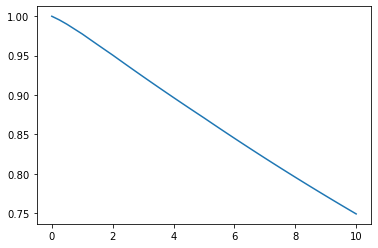

In [54]:
plt.plot(DF["T"], DF["DF"])

Text(0, 0.5, 'Interest Rate')

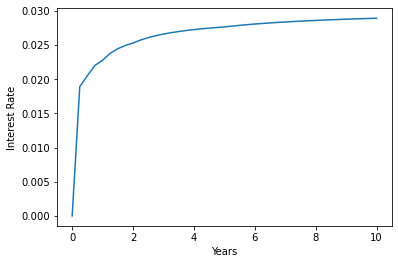

In [59]:
# Zero rate
plt.plot(DF["T"], DF["r"])
plt.xlabel("Years")
plt.ylabel("Interest Rate")
#plt.savefig("Interest_Rate.png")

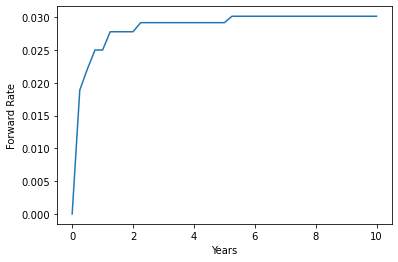

In [57]:
# Forward rate
plt.plot(DF["T"], DF["fwd"])
plt.xlabel("Years")
plt.ylabel("Forward Rate")
#plt.savefig(path+ "Forward_rate.png")

From this we can see that $f_j \geq f_i \quad \forall i\leq j$ as expected <br>(as per PATRICK S. HAGAN & GRAEME WEST paper)

In [52]:
DF.to_csv(path+"20180620_DiscountFactor_bloomberg_interpolated.csv")#.iloc[:,1:]

In [53]:
DF

,T,DF,r,fwd
0,0.00,1.000000,0.000000,0.000000
1,0.25,0.995287,0.018895,0.018895
2,0.50,0.989800,0.020505,0.022115
3,0.75,0.983631,0.022006,0.025009
4,1.00,0.977500,0.022757,0.025009
5,1.25,0.970730,0.023765,0.027799
6,1.50,0.964007,0.024438,0.027799
7,1.75,0.957331,0.024918,0.027799
8,2.00,0.950701,0.025278,0.027799
9,2.25,0.943790,0.025712,0.029185
